# House price regression: price prediction

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

pd.set_option('display.max_columns', 500)

## Import data

In [2]:
df_train = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_trainset.csv")
df_train = df_train.drop(['Unnamed: 0'], axis=1)

df_test = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_testset.csv")
df_test = df_test.drop(['Unnamed: 0'], axis=1)

df_train_OHE = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_trainset_OHE.csv")
df_train_OHE = df_train_OHE.drop(['Unnamed: 0'], axis=1)

df_test_OHE = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_testset_OHE.csv")
df_test_OHE = df_test_OHE.drop(['Unnamed: 0'], axis=1)

continuous_features = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/continuous_features.txt", 'rb'))
categorical_features = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/categorical_features.txt", 'rb'))

scaler_continuous = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/scaler_continuous.txt", 'rb'))
le_categorical = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/le_categorical.txt", 'rb'))


for feature in categorical_features:
    df_train[feature] = df_train[feature].astype('category')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0.067331,3,-0.184481,-0.217879,1,1,3,3,0,4,0,5,2,2,0,5,0.646183,-0.507284,-1.046258,-0.896833,1,1,13,13,1,0.529034,2,4,2,2,4,3,2,0.581145,6,-0.293025,-0.934165,-0.443078,1,0,1,4,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,2,0.986849,6,-0.924311,3,1,0.294975,2,0.307040,0.349364,5,5,2,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,-1.552184,-0.157646,8,4,0.347273
1,2,-0.873616,3,0.458190,-0.072044,1,1,3,3,0,2,0,24,1,2,0,2,-0.063185,2.188279,-0.154764,0.395604,1,1,8,8,3,-0.567016,3,4,1,2,4,1,0,1.178255,6,-0.293025,-0.629284,0.477463,1,0,1,4,0.261075,-0.785025,-0.101197,-0.471891,-0.818929,3.822508,0.781366,-0.756321,0.169927,-0.207698,3,-0.287758,6,0.623632,5,1,0.234953,2,0.307040,-0.058991,5,5,2,1.614879,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,-0.446925,0.602962,8,4,0.007288
2,3,0.067331,3,-0.055946,0.137197,1,1,0,3,0,4,0,5,2,2,0,5,0.646183,-0.507284,-0.980221,-0.848965,1,1,13,13,1,0.338903,2,4,2,2,4,2,2,0.098189,6,-0.293025,-0.287999,-0.297968,1,0,1,4,-0.610718,1.235375,-0.101197,0.563755,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,2,-0.287758,6,0.623632,5,1,0.290529,2,0.307040,0.627787,5,5,2,-0.740760,-0.081209,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,1.026753,-0.157646,8,4,0.536154
3,4,0.302568,3,-0.398704,-0.078385,1,1,0,3,0,0,0,6,2,2,0,5,0.646183,-0.507284,1.859351,0.682812,1,1,14,15,3,-0.567016,3,4,0,4,1,3,0,-0.494529,6,-0.293025,-0.046824,-0.669812,1,2,1,4,-0.506205,0.978742,-0.101197,0.427382,1.087334,-0.249719,-1.027363,-0.756321,0.169927,-0.207698,2,0.349546,6,0.623632,2,5,0.283860,3,1.619264,0.785561,5,5,2,-0.740760,-0.184815,3.874967,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,-1.552184,1.363569,8,0,-0.515281
4,5,0.067331,3,0.629569,0.518903,1,1,0,3,0,2,0,15,2,2,0,5,1.355551,-0.507284,-0.947203,-0.753229,1,1,13,13,1,1.390216,2,4,2,2,4,0,2,0.469187,6,-0.293025,-0.160586,0.212184,1,0,1,4,-0.037170,1.671651,-0.101197,1.378042,1.087334,-0.249719,0.781366,1.232599,1.385655,-0.207698,2,1.624153,6,0.623632,5,1,0.288306,2,1.619264,1.685798,5,5,2,0.776967,0.540424,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,2.132012,-0.157646,8,4,0.869843


In [4]:
df_train_OHE.head()

,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_0,Street_1,Alley_0,Alley_1,Alley_2,LotShape_0,LotShape_1,LotShape_2,LotShape_3,LandContour_0,LandContour_1,LandContour_2,LandContour_3,Utilities_0,Utilities_1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior1st_15,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,FireplaceQu_0,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,FireplaceQu_5,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_0,PavedDrive_1,PavedDrive_2,PoolQC_0,PoolQC_1,PoolQC_2,PoolQC_3,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Id,SalePrice
0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Regression sale price against lot frontage

regression coefficient:  [[0.3481957]]


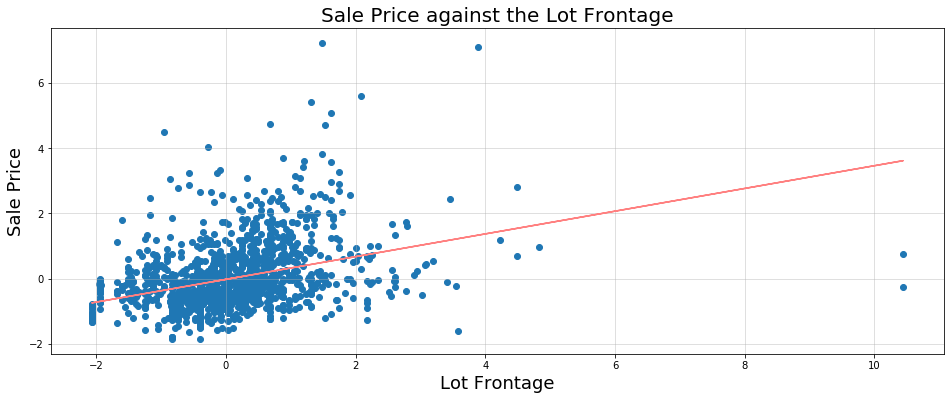

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))
X, y = df_train["LotFrontage"], df_train["SalePrice"]
X, y = X[X.notnull()].values, y[X.notnull()].values
X, y = X.reshape(X.shape[0], 1), y.reshape(y.shape[0], 1)
plt.scatter(X, y)
plt.grid(alpha=.5)

reg = LinearRegression()
reg.fit(X, y)
line = reg.predict(X)

plt.plot(X, line, color=(1, .5, .5))
plt.xlabel('Lot Frontage', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Sale Price against the Lot Frontage', fontsize=20)
print('regression coefficient: ', reg.coef_)

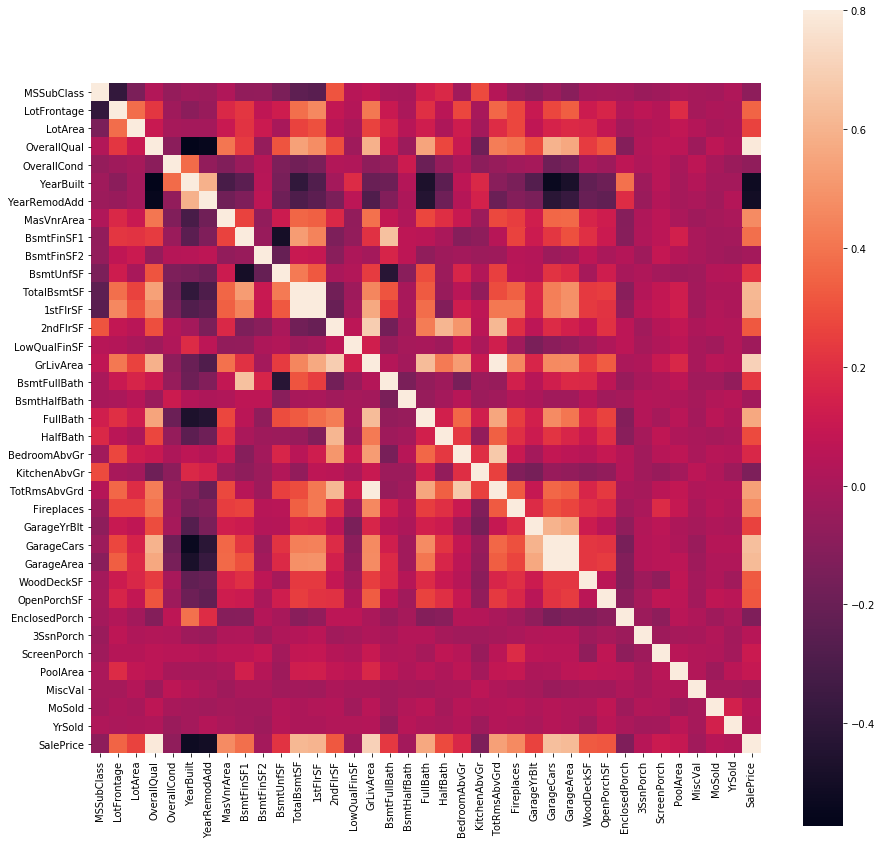

In [27]:
C_mat = (df_train[continuous_features]).corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

## First model: Random Forest

In [48]:

X = df_train_OHE.drop(['Id', 'SalePrice'], axis=1)
y = df_train_OHE['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)
"""
X = df_train.drop(['Id', 'SalePrice'], axis=1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)
"""

"\nX = df_train.drop(['Id', 'SalePrice'], axis=1)\ny = df_train['SalePrice']\nX_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)\n"

In [12]:
#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestRegressor(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=4)
grid_search.fit(X_train, y_train.values)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.278, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.302, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.306, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.378, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.345, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_features=4, n_estimators=5, score=0.314, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.342, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.423, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.357, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.400, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.428, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=25 ....................
[CV]  max_depth=3, max_features=4, n_estimators=25, score=0.406, total=   0.1s
[CV] max_depth=3, max_features=4, n_estimators=25 ....................
[CV]  max_depth=3, max_features=4, n_estimators=25, score=0.452, total=   0.1s
[CV] max_depth=3, max

[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.648, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.595, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.666, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.695, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=50 ...................
[CV]  max_depth=3, max_features=15, n_estimators=50, score=0.670, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=50 ...................
[CV]  max_depth=3, max_features=15, n_estimators=50, score=0.634, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=50 ...................
[CV]  max_depth=3, max_features=15, n_estimators=50, score=0.611, total=   0.1s
[CV] max_depth

[CV]  max_depth=5, max_features=4, n_estimators=50, score=0.532, total=   0.1s
[CV] max_depth=5, max_features=4, n_estimators=50 ....................
[CV]  max_depth=5, max_features=4, n_estimators=50, score=0.602, total=   0.1s
[CV] max_depth=5, max_features=4, n_estimators=50 ....................
[CV]  max_depth=5, max_features=4, n_estimators=50, score=0.610, total=   0.1s
[CV] max_depth=5, max_features=7, n_estimators=3 .....................
[CV]  max_depth=5, max_features=7, n_estimators=3, score=0.663, total=   0.0s
[CV] max_depth=5, max_features=7, n_estimators=3 .....................
[CV]  max_depth=5, max_features=7, n_estimators=3, score=0.565, total=   0.0s
[CV] max_depth=5, max_features=7, n_estimators=3 .....................
[CV]  max_depth=5, max_features=7, n_estimators=3, score=0.560, total=   0.0s
[CV] max_depth=5, max_features=7, n_estimators=3 .....................
[CV]  max_depth=5, max_features=7, n_estimators=3, score=0.579, total=   0.0s
[CV] max_depth=5, max_fea

[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.713, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.672, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.710, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.724, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.705, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.757, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.752, total=   0.0s
[CV] max_depth=5, max

[CV]  max_depth=7, max_features=7, n_estimators=5, score=0.700, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=10 ....................
[CV]  max_depth=7, max_features=7, n_estimators=10, score=0.673, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=10 ....................
[CV]  max_depth=7, max_features=7, n_estimators=10, score=0.663, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=10 ....................
[CV]  max_depth=7, max_features=7, n_estimators=10, score=0.682, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=10 ....................
[CV]  max_depth=7, max_features=7, n_estimators=10, score=0.741, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=10 ....................
[CV]  max_depth=7, max_features=7, n_estimators=10, score=0.751, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=25 ....................
[CV]  max_depth=7, max_features=7, n_estimators=25, score=0.736, total=   0.1s
[CV] max_depth=7, max_

[CV]  max_depth=7, max_features=20, n_estimators=25, score=0.693, total=   0.1s
[CV] max_depth=7, max_features=20, n_estimators=25 ...................
[CV]  max_depth=7, max_features=20, n_estimators=25, score=0.791, total=   0.1s
[CV] max_depth=7, max_features=20, n_estimators=25 ...................
[CV]  max_depth=7, max_features=20, n_estimators=25, score=0.821, total=   0.1s
[CV] max_depth=7, max_features=20, n_estimators=25 ...................
[CV]  max_depth=7, max_features=20, n_estimators=25, score=0.840, total=   0.1s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.817, total=   0.2s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.686, total=   0.2s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.797, total=   0.2s
[CV] max_depth

[CV]  max_depth=10, max_features=7, n_estimators=50, score=0.708, total=   0.1s
[CV] max_depth=10, max_features=7, n_estimators=50 ...................
[CV]  max_depth=10, max_features=7, n_estimators=50, score=0.759, total=   0.1s
[CV] max_depth=10, max_features=7, n_estimators=50 ...................
[CV]  max_depth=10, max_features=7, n_estimators=50, score=0.788, total=   0.1s
[CV] max_depth=10, max_features=7, n_estimators=50 ...................
[CV]  max_depth=10, max_features=7, n_estimators=50, score=0.816, total=   0.2s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.823, total=   0.0s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.604, total=   0.0s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.734, total=   0.0s
[CV] max_depth

[CV]  max_depth=None, max_features=4, n_estimators=5, score=0.683, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.734, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.736, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.668, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.776, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.754, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=25 .................
[CV]  max_depth=None, max_features=4, n_estimators=25, score=0.750, total=   0.1s
[

[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.804, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.654, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.780, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.840, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.865, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=50 ................
[CV]  max_depth=None, max_features=15, n_estimators=50, score=0.817, total=   0.2s
[CV] max_depth=None, max_features=15, n_estimators=50 ................
[CV]  max_depth=None, max_features=15, n_estimators=50, score=0.684, total= 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   34.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [13]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8172468494800842
{'max_depth': None, 'max_features': 20, 'n_estimators': 25}


In [24]:
rf = RandomForestRegressor(max_depth=None, max_features=20, n_estimators=25, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [25]:
prediction = rf.predict(X_test)

y_test_inverse = scaler_continuous['SalePrice'].inverse_transform(y_test)
log_y_test_inverse = np.log(y_test_inverse)

prediction_inverse = scaler_continuous['SalePrice'].inverse_transform(prediction)
log_prediction_inverse = np.log(prediction_inverse)
print('MSE for RF: ', mean_squared_error(log_y_test_inverse, log_prediction_inverse))

MSE for RF:  0.022638451850761625


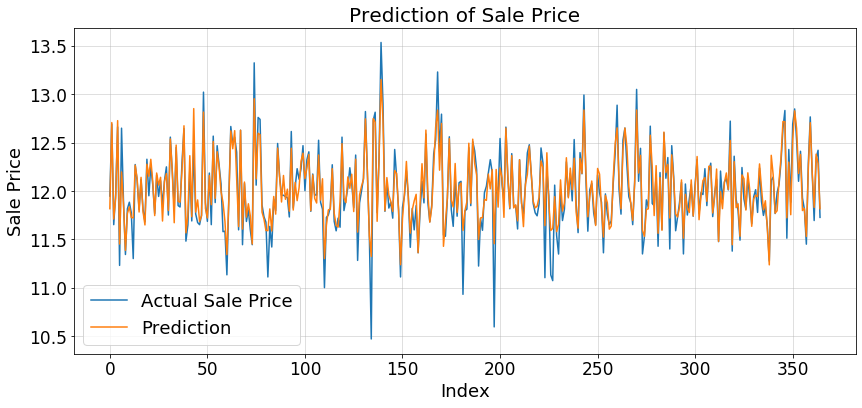

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(log_y_test_inverse, label='Actual Sale Price')
plt.plot(log_prediction_inverse, label='Prediction')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Prediction of Sale Price', fontsize = 20)
plt.grid(alpha=.5)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)

## Second model: Dense Neural Network

In [34]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
optimizer = Adam(learning_rate=1e-4)
NN_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['acc'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               10240     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 175,105
Trainable params: 175,105
Non-trainable params: 0
_________________________________________________________________


In [35]:
NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data = (X_test, y_test))
optimizer = Adam(learning_rate=4e-5)
NN_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['acc'])
NN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data = (X_test, y_test))

Train on 1095 samples, validate on 365 samples
Epoch 1/100
1095/1095 [==============================] - 1s 1ms/sample - loss: 0.6422 - acc: 0.0000e+00 - val_loss: 0.5572 - val_acc: 0.0000e+00
Epoch 2/100
1095/1095 [==============================] - 0s 338us/sample - loss: 0.4247 - acc: 0.0000e+00 - val_loss: 0.3540 - val_acc: 0.0000e+00
Epoch 3/100
1095/1095 [==============================] - 0s 343us/sample - loss: 0.3077 - acc: 0.0000e+00 - val_loss: 0.2901 - val_acc: 0.0000e+00
Epoch 4/100
1095/1095 [==============================] - 0s 344us/sample - loss: 0.2626 - acc: 0.0000e+00 - val_loss: 0.2588 - val_acc: 0.0000e+00
Epoch 5/100
1095/1095 [==============================] - 0s 345us/sample - loss: 0.2410 - acc: 0.0000e+00 - val_loss: 0.2447 - val_acc: 0.0000e+00
Epoch 6/100
1095/1095 [==============================] - 0s 345us/sample - loss: 0.2217 - acc: 0.0000e+00 - val_loss: 0.2334 - val_acc: 0.0000e+00
Epoch 7/100
1095/1095 [==============================] - 0s 383us/sample 

1095/1095 [==============================] - 0s 372us/sample - loss: 0.1046 - acc: 0.0000e+00 - val_loss: 0.1999 - val_acc: 0.0000e+00
Epoch 57/100
1095/1095 [==============================] - 0s 364us/sample - loss: 0.0912 - acc: 0.0000e+00 - val_loss: 0.2034 - val_acc: 0.0000e+00
Epoch 58/100
1095/1095 [==============================] - 0s 410us/sample - loss: 0.0835 - acc: 0.0000e+00 - val_loss: 0.1976 - val_acc: 0.0000e+00
Epoch 59/100
1095/1095 [==============================] - 1s 510us/sample - loss: 0.0850 - acc: 0.0000e+00 - val_loss: 0.1991 - val_acc: 0.0000e+00
Epoch 60/100
1095/1095 [==============================] - 0s 456us/sample - loss: 0.0869 - acc: 0.0000e+00 - val_loss: 0.1972 - val_acc: 0.0000e+00
Epoch 61/100
1095/1095 [==============================] - 1s 496us/sample - loss: 0.0809 - acc: 0.0000e+00 - val_loss: 0.1970 - val_acc: 0.0000e+00
Epoch 62/100
1095/1095 [==============================] - 0s 396us/sample - loss: 0.0804 - acc: 0.0000e+00 - val_loss: 0.1972

1095/1095 [==============================] - 0s 389us/sample - loss: 0.0450 - acc: 0.0000e+00 - val_loss: 0.2021 - val_acc: 0.0000e+00
Epoch 12/50
1095/1095 [==============================] - 0s 385us/sample - loss: 0.0448 - acc: 0.0000e+00 - val_loss: 0.2021 - val_acc: 0.0000e+00
Epoch 13/50
1095/1095 [==============================] - 0s 446us/sample - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.2036 - val_acc: 0.0000e+00
Epoch 14/50
1095/1095 [==============================] - 1s 495us/sample - loss: 0.0449 - acc: 0.0000e+00 - val_loss: 0.2046 - val_acc: 0.0000e+00
Epoch 15/50
1095/1095 [==============================] - 1s 530us/sample - loss: 0.0425 - acc: 0.0000e+00 - val_loss: 0.2043 - val_acc: 0.0000e+00
Epoch 16/50
1095/1095 [==============================] - 1s 557us/sample - loss: 0.0437 - acc: 0.0000e+00 - val_loss: 0.2027 - val_acc: 0.0000e+00
Epoch 17/50
1095/1095 [==============================] - 1s 495us/sample - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.2037 - val

In [36]:
prediction_nn = NN_model.predict(X_test)
prediction_nn_inverse = scaler_continuous['SalePrice'].inverse_transform(prediction_nn)
log_prediction_nn_inverse = np.log(prediction_nn_inverse)
print('MSE for NN: ', mean_squared_error(log_y_test_inverse, log_prediction_nn_inverse))

MSE for NN:  0.01986034654569929


## Graphical comparison of prediction

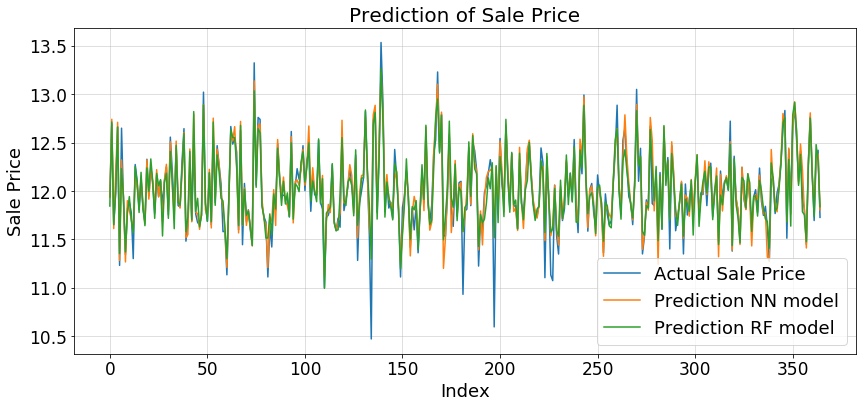

In [123]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(log_y_test_inverse, label='Actual Sale Price')
plt.plot(log_prediction_nn_inverse, label='Prediction NN model')
plt.plot(log_prediction_inverse, label='Prediction RF model')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Prediction of Sale Price', fontsize = 20)
plt.grid(alpha=.5)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)

In [23]:
df_train_OHE.head()

,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_0,Street_1,Alley_0,Alley_1,Alley_2,LotShape_0,LotShape_1,LotShape_2,LotShape_3,LandContour_0,LandContour_1,LandContour_2,LandContour_3,Utilities_0,Utilities_1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior1st_15,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,FireplaceQu_0,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,FireplaceQu_5,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_0,PavedDrive_1,PavedDrive_2,PoolQC_0,PoolQC_1,PoolQC_2,PoolQC_3,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [36]:
X, y = df_train_OHE.drop(['Id', 'SalePrice'], axis=1), df_train_OHE['SalePrice']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

## Third model: XGBoost

In [62]:
#Seting the Hyper Parameters
param_grid = {"learning_rate": [1e-1, 5e-2, 1e-2],
              "n_estimators":[800, 1000, 1100],
              "max_depth": [2, 3, 4, 5, 7]}

#Creating the classifier
model = XGBRegressor()

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=4)
grid_search.fit(X_train, y_train.values)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] learning_rate=0.1, max_depth=2, n_estimators=800 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=2, n_estimators=800, score=0.867, total=   3.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=800 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, n_estimators=800, score=0.423, total=   2.9s
[CV] learning_rate=0.1, max_depth=2, n_estimators=800 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, n_estimators=800, score=0.892, total=   2.9s
[CV] learning_rate=0.1, max_depth=2, n_estimators=800 ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, n_estimators=800, score=0.882, total=   2.9s
[CV] learning_rate=0.1, max_depth=2, n_estimators=800 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=800, score=0.913, total=   2.8s
[CV] learning_rate=0.1, max_depth=2, n_estimators=1000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=1000, score=0.867, total=   3.6s
[CV] learning_rate=0.1, max_depth=2, n_estimators=1000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=1000, score=0.430, total=   3.9s
[CV] learning_rate=0.1, max_depth=2, n_estimators=1000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=1000, score=0.892, total=   3.6s
[CV] learning_rate=0.1, max_depth=2, n_estimators=1000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=1000, score=0.882, total=   3.6s
[CV] learning_rate=0.1, max_depth=2, n_estimators=1000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=1000, score=0.914, to

[CV]  learning_rate=0.1, max_depth=5, n_estimators=1100, score=0.439, total=   7.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1100 ...............
[CV]  learning_rate=0.1, max_depth=5, n_estimators=1100, score=0.883, total=   7.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1100 ...............
[CV]  learning_rate=0.1, max_depth=5, n_estimators=1100, score=0.893, total=   8.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1100 ...............
[CV]  learning_rate=0.1, max_depth=5, n_estimators=1100, score=0.879, total=   8.7s
[CV] learning_rate=0.1, max_depth=7, n_estimators=800 ................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=800, score=0.850, total=   5.7s
[CV] learning_rate=0.1, max_depth=7, n_estimators=800 ................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=800, score=0.387, total=   5.2s
[CV] learning_rate=0.1, max_depth=7, n_estimators=800 ................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=800, score=0.862, tot

[CV]  learning_rate=0.05, max_depth=4, n_estimators=800, score=0.898, total=   5.0s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, score=0.878, total=   6.5s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, score=0.493, total=   6.6s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, score=0.884, total=   6.4s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, score=0.885, total=   6.5s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, score=0.898, total=   6.3s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1100 ..............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1100, score=0

[CV]  learning_rate=0.01, max_depth=2, n_estimators=1100, score=0.877, total=   3.9s
[CV] learning_rate=0.01, max_depth=2, n_estimators=1100 ..............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=1100, score=0.873, total=   3.9s
[CV] learning_rate=0.01, max_depth=2, n_estimators=1100 ..............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=1100, score=0.895, total=   4.6s
[CV] learning_rate=0.01, max_depth=3, n_estimators=800 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=800, score=0.873, total=   4.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=800 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=800, score=0.476, total=   3.8s
[CV] learning_rate=0.01, max_depth=3, n_estimators=800 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=800, score=0.876, total=   3.9s
[CV] learning_rate=0.01, max_depth=3, n_estimators=800 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=800, score=0.87

[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.852, total=  10.6s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.428, total=  10.1s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.876, total=  10.4s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.879, total=  10.1s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.855, total=  10.5s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1100 ..............
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1100, score=0.852, total=  11.2s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1100 ..............
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1100, score=

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 23.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=Non

In [63]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8075033632034561
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 1000}


In [64]:
XGBModel = XGBRegressor(learning_rate= 0.05, max_depth= 4, n_estimators= 1000)
XGBModel.fit(X_train, y_train , verbose=1)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
prediction_xgb_inverse = scaler_continuous['SalePrice'].inverse_transform(XGBpredictions)
log_prediction_xgb_inverse = np.log(prediction_xgb_inverse)
MAE = mean_squared_error(log_y_test_inverse , log_prediction_xgb_inverse)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  0.016481909773744904


## 4th model: ElasticNet

In [71]:
#Seting the Hyper Parameters
param_grid = {"l1_ratio": [0, .25, .5, .75, 1],
              "max_iter":[100, 200, 300, 500]}

#Creating the classifier
model = ElasticNet()

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=4)
grid_search.fit(X_train, y_train.values)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] l1_ratio=0, max_iter=100 ........................................
[CV] ............ l1_ratio=0, max_iter=100, score=0.766, total=   0.1s
[CV] l1_ratio=0, max_iter=100 ........................................
[CV] ............ l1_ratio=0, max_iter=100, score=0.464, total=   0.0s
[CV] l1_ratio=0, max_iter=100 ........................................
[CV] ............ l1_ratio=0, max_iter=100, score=0.783, total=   0.0s
[CV] l1_ratio=0, max_iter=100 ........................................
[CV] ............ l1_ratio=0, max_iter=100, score=0.856, total=   0.0s
[CV] l1_ratio=0, max_iter=100 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.31430355760287, tolerance: 0.07885337460535229
  positive)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.81424206531972, tolerance: 0.08857906341648183
  positive)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

[CV] ............ l1_ratio=0, max_iter=100, score=0.843, total=   0.1s
[CV] l1_ratio=0, max_iter=200 ........................................
[CV] ............ l1_ratio=0, max_iter=200, score=0.766, total=   0.1s
[CV] l1_ratio=0, max_iter=200 ........................................
[CV] ............ l1_ratio=0, max_iter=200, score=0.464, total=   0.1s
[CV] l1_ratio=0, max_iter=200 ........................................


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.88126884045332, tolerance: 0.07981462237108625
  positive)
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.93649699854987, tolerance: 0.08678199568407793
  positive)
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.0738229643293, tolerance: 0.08754792263760862
  positive)


[CV] ............ l1_ratio=0, max_iter=200, score=0.783, total=   0.1s
[CV] l1_ratio=0, max_iter=200 ........................................
[CV] ............ l1_ratio=0, max_iter=200, score=0.856, total=   0.1s
[CV] l1_ratio=0, max_iter=200 ........................................
[CV] ............ l1_ratio=0, max_iter=200, score=0.843, total=   0.1s
[CV] l1_ratio=0, max_iter=300 ........................................


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.31430355760281, tolerance: 0.07885337460535229
  positive)
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.81424206531977, tolerance: 0.08857906341648183
  positive)


[CV] ............ l1_ratio=0, max_iter=300, score=0.766, total=   0.1s
[CV] l1_ratio=0, max_iter=300 ........................................
[CV] ............ l1_ratio=0, max_iter=300, score=0.464, total=   0.1s
[CV] l1_ratio=0, max_iter=300 ........................................


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.88126884045323, tolerance: 0.07981462237108625
  positive)
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.93649699854998, tolerance: 0.08678199568407793
  positive)


[CV] ............ l1_ratio=0, max_iter=300, score=0.783, total=   0.1s
[CV] l1_ratio=0, max_iter=300 ........................................
[CV] ............ l1_ratio=0, max_iter=300, score=0.856, total=   0.1s
[CV] l1_ratio=0, max_iter=300 ........................................


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.07382296432937, tolerance: 0.08754792263760862
  positive)
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.31430355760281, tolerance: 0.07885337460535229
  positive)


[CV] ............ l1_ratio=0, max_iter=300, score=0.843, total=   0.1s
[CV] l1_ratio=0, max_iter=500 ........................................
[CV] ............ l1_ratio=0, max_iter=500, score=0.766, total=   0.2s
[CV] l1_ratio=0, max_iter=500 ........................................


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.81424206531995, tolerance: 0.08857906341648183
  positive)
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.88126884045326, tolerance: 0.07981462237108625
  positive)


[CV] ............ l1_ratio=0, max_iter=500, score=0.464, total=   0.2s
[CV] l1_ratio=0, max_iter=500 ........................................
[CV] ............ l1_ratio=0, max_iter=500, score=0.783, total=   0.2s
[CV] l1_ratio=0, max_iter=500 ........................................


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.93649699855007, tolerance: 0.08678199568407793
  positive)
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.0738229643294, tolerance: 0.08754792263760862
  positive)


[CV] ............ l1_ratio=0, max_iter=500, score=0.856, total=   0.2s
[CV] l1_ratio=0, max_iter=500 ........................................
[CV] ............ l1_ratio=0, max_iter=500, score=0.843, total=   0.2s
[CV] l1_ratio=0.25, max_iter=100 .....................................
[CV] ......... l1_ratio=0.25, max_iter=100, score=0.529, total=   0.0s
[CV] l1_ratio=0.25, max_iter=100 .....................................
[CV] ......... l1_ratio=0.25, max_iter=100, score=0.516, total=   0.0s
[CV] l1_ratio=0.25, max_iter=100 .....................................
[CV] ......... l1_ratio=0.25, max_iter=100, score=0.533, total=   0.0s
[CV] l1_ratio=0.25, max_iter=100 .....................................
[CV] ......... l1_ratio=0.25, max_iter=100, score=0.603, total=   0.0s
[CV] l1_ratio=0.25, max_iter=100 .....................................
[CV] ......... l1_ratio=0.25, max_iter=100, score=0.599, total=   0.0s
[CV] l1_ratio=0.25, max_iter=200 .....................................
[CV] .

[CV] ........... l1_ratio=1, max_iter=300, score=-0.011, total=   0.0s
[CV] l1_ratio=1, max_iter=300 ........................................
[CV] ........... l1_ratio=1, max_iter=300, score=-0.000, total=   0.0s
[CV] l1_ratio=1, max_iter=300 ........................................
[CV] ........... l1_ratio=1, max_iter=300, score=-0.008, total=   0.0s
[CV] l1_ratio=1, max_iter=300 ........................................
[CV] ........... l1_ratio=1, max_iter=300, score=-0.001, total=   0.0s
[CV] l1_ratio=1, max_iter=300 ........................................
[CV] ........... l1_ratio=1, max_iter=300, score=-0.000, total=   0.0s
[CV] l1_ratio=1, max_iter=500 ........................................
[CV] ........... l1_ratio=1, max_iter=500, score=-0.011, total=   0.0s
[CV] l1_ratio=1, max_iter=500 ........................................
[CV] ........... l1_ratio=1, max_iter=500, score=-0.000, total=   0.0s
[CV] l1_ratio=1, max_iter=500 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.55932709926034, tolerance: 0.10541390960048723
  positive)


GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'max_iter': [100, 200, 300, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=4)

In [72]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7423640876509785
{'l1_ratio': 0, 'max_iter': 200}


In [74]:
ElasticNetModel = ElasticNet(l1_ratio=0, max_iter=200)
ElasticNetModel.fit(X_train, y_train)

# Get the mean absolute error on the validation data :
ElasticNetpredictions = ElasticNetModel.predict(X_test)
prediction_ElasticNet_inverse = scaler_continuous['SalePrice'].inverse_transform(ElasticNetpredictions)
log_prediction_ElasticNet_inverse = np.log(prediction_ElasticNet_inverse)
MAE = mean_squared_error(log_y_test_inverse , log_prediction_ElasticNet_inverse)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  0.0238244224316743


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.55932709926034, tolerance: 0.10541390960048723
  positive)


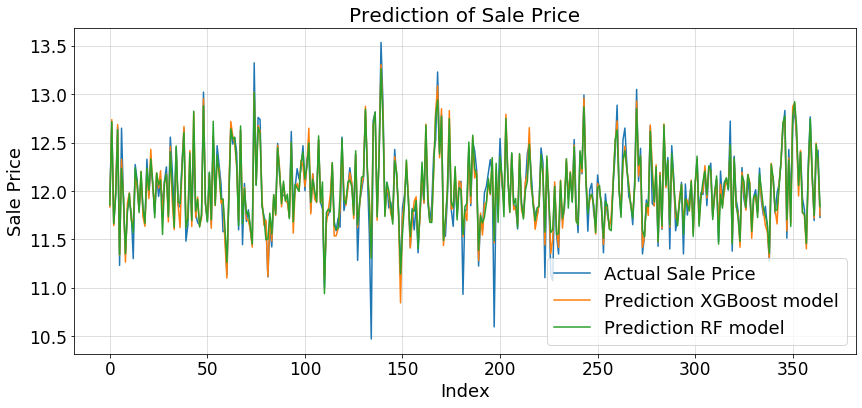

In [45]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(log_y_test_inverse, label='Actual Sale Price')
plt.plot(log_prediction_xgb_inverse, label='Prediction XGBoost model')
plt.plot(log_prediction_inverse, label='Prediction RF model')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Prediction of Sale Price', fontsize = 20)
plt.grid(alpha=.5)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)

The neural network model provides better performances.
The same model is now trained on the whole training set, to predict the test set for submission

In [41]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
optimizer = Adam(learning_rate=1e-4)
NN_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['acc'])
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               10240     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 175,105
Trainable params: 175,105
Non-trainable params: 0
_________________________________________________________________


In [42]:
X_train = df_train.drop(['SalePrice', 'Id'], axis=1)
y_train = df_train['SalePrice']
NN_model.fit(X_train, y_train, epochs=100, batch_size=32)

optimizer = Adam(learning_rate=4e-5)
NN_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['acc'])
NN_model.fit(X_train, y_train, epochs=150, batch_size=32)

Train on 1460 samples
Epoch 1/100
1460/1460 [==============================] - 1s 729us/sample - loss: 0.6195 - acc: 0.0000e+00
Epoch 2/100
1460/1460 [==============================] - 0s 310us/sample - loss: 0.3599 - acc: 0.0000e+00
Epoch 3/100
1460/1460 [==============================] - 0s 338us/sample - loss: 0.2715 - acc: 0.0000e+00
Epoch 4/100
1460/1460 [==============================] - 0s 335us/sample - loss: 0.2376 - acc: 0.0000e+00
Epoch 5/100
1460/1460 [==============================] - 0s 320us/sample - loss: 0.2211 - acc: 0.0000e+00
Epoch 6/100
1460/1460 [==============================] - 1s 370us/sample - loss: 0.2091 - acc: 0.0000e+00
Epoch 7/100
1460/1460 [==============================] - 1s 373us/sample - loss: 0.2086 - acc: 0.0000e+00
Epoch 8/100
1460/1460 [==============================] - 1s 345us/sample - loss: 0.1936 - acc: 0.0000e+00
Epoch 9/100
1460/1460 [==============================] - 1s 399us/sample - loss: 0.1941 - acc: 0.0000e+00
Epoch 10/100
1460/1460 [

1460/1460 [==============================] - 1s 616us/sample - loss: 0.0706 - acc: 0.0000e+00
Epoch 78/100
1460/1460 [==============================] - 0s 337us/sample - loss: 0.0700 - acc: 0.0000e+00
Epoch 79/100
1460/1460 [==============================] - 1s 382us/sample - loss: 0.0709 - acc: 0.0000e+00
Epoch 80/100
1460/1460 [==============================] - 1s 438us/sample - loss: 0.0685 - acc: 0.0000e+00
Epoch 81/100
1460/1460 [==============================] - 1s 454us/sample - loss: 0.0740 - acc: 0.0000e+00
Epoch 82/100
1460/1460 [==============================] - 1s 446us/sample - loss: 0.0709 - acc: 0.0000e+00
Epoch 83/100
1460/1460 [==============================] - 1s 615us/sample - loss: 0.0635 - acc: 0.0000e+00
Epoch 84/100
1460/1460 [==============================] - 1s 508us/sample - loss: 0.0654 - acc: 0.0000e+00
Epoch 85/100
1460/1460 [==============================] - 1s 563us/sample - loss: 0.0680 - acc: 0.0000e+00
Epoch 86/100
1460/1460 [==========================

1460/1460 [==============================] - 0s 332us/sample - loss: 0.0348 - acc: 0.0000e+00
Epoch 54/150
1460/1460 [==============================] - 1s 382us/sample - loss: 0.0341 - acc: 0.0000e+00
Epoch 55/150
1460/1460 [==============================] - 1s 485us/sample - loss: 0.0361 - acc: 0.0000e+00
Epoch 56/150
1460/1460 [==============================] - 1s 925us/sample - loss: 0.0322 - acc: 0.0000e+00
Epoch 57/150
1460/1460 [==============================] - 1s 744us/sample - loss: 0.0327 - acc: 0.0000e+00
Epoch 58/150
1460/1460 [==============================] - 1s 613us/sample - loss: 0.0319 - acc: 0.0000e+00
Epoch 59/150
1460/1460 [==============================] - 1s 684us/sample - loss: 0.0325 - acc: 0.0000e+00
Epoch 60/150
1460/1460 [==============================] - 1s 630us/sample - loss: 0.0320 - acc: 0.0000e+00
Epoch 61/150
1460/1460 [==============================] - 1s 533us/sample - loss: 0.0327 - acc: 0.0000e+00
Epoch 62/150
1460/1460 [==========================

1460/1460 [==============================] - 1s 414us/sample - loss: 0.0270 - acc: 0.0000e+00
Epoch 130/150
1460/1460 [==============================] - 1s 372us/sample - loss: 0.0258 - acc: 0.0000e+00
Epoch 131/150
1460/1460 [==============================] - 0s 328us/sample - loss: 0.0246 - acc: 0.0000e+00
Epoch 132/150
1460/1460 [==============================] - 1s 404us/sample - loss: 0.0270 - acc: 0.0000e+00
Epoch 133/150
1460/1460 [==============================] - 1s 381us/sample - loss: 0.0253 - acc: 0.0000e+00
Epoch 134/150
1460/1460 [==============================] - 1s 476us/sample - loss: 0.0257 - acc: 0.0000e+00
Epoch 135/150
1460/1460 [==============================] - 1s 397us/sample - loss: 0.0260 - acc: 0.0000e+00
Epoch 136/150
1460/1460 [==============================] - 0s 341us/sample - loss: 0.0238 - acc: 0.0000e+00
Epoch 137/150
1460/1460 [==============================] - 0s 339us/sample - loss: 0.0235 - acc: 0.0000e+00
Epoch 138/150
1460/1460 [=================

## Submission with XGBoost prediction

In [65]:
XGBModel = XGBRegressor(learning_rate= 0.05, max_depth= 4, n_estimators= 1000)
XGBModel.fit(X, y , verbose=1)

X_test_OHE = df_test_OHE.drop(['Id'], axis=1)
XGBpredictions = XGBModel.predict(X_test_OHE)
prediction_xgb_inverse = scaler_continuous['SalePrice'].inverse_transform(XGBpredictions)

In [66]:
submission =pd.DataFrame()
submission['Id'] = df_test['Id']
submission['SalePrice'] = prediction_xgb_inverse
submission.head()

,Id,SalePrice
0,1461,125585.007812
1,1462,164029.156250
2,1463,183397.390625
3,1464,194358.015625
4,1465,180650.328125


## Submission with NN

In [43]:
X_test = df_test.drop(['Id'], axis=1)
final_prediction = NN_model.predict(X_test)
final_prediction = scaler_continuous['SalePrice'].inverse_transform(final_prediction)
submission =pd.DataFrame()
submission['Id'] = df_test['Id']
submission['SalePrice'] = final_prediction
submission.head()

,Id,SalePrice
0,1461,123888.921875
1,1462,183323.156250
2,1463,187238.625000
3,1464,200488.265625
4,1465,174483.109375


## Submission with RF

In [28]:
RFModel = RandomForestRegressor(max_depth=None, max_features=20, n_estimators=25, random_state=0)
RFModel.fit(X, y)

X_test_OHE = df_test_OHE.drop(['Id'], axis=1)
RFpredictions = RFModel.predict(X_test_OHE)
prediction_rf_inverse = scaler_continuous['SalePrice'].inverse_transform(RFpredictions)

In [29]:
submission =pd.DataFrame()
submission['Id'] = df_test['Id']
submission['SalePrice'] = prediction_rf_inverse
submission.head()

,Id,SalePrice
0,1461,116508.0
1,1462,156006.0
2,1463,180861.6
3,1464,192196.0
4,1465,187363.0


## CSV submission

In [67]:
vg_submission = submission.to_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/vg_submission8_xgb.csv", index=False)

In [50]:
sub = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/vg_submission3_xgb.csv")

In [51]:
sub.head()

,Id,SalePrice
0,1461,130804.89
1,1462,162521.33
2,1463,191522.28
3,1464,197519.34
4,1465,188635.44
